In [ ]:
%%capture
!wget -N https://github.com/Shenggan/BCCD_Dataset/archive/refs/tags/v1.0.zip

In [ ]:
%%capture
!unzip /content/v1.0.zip

In [ ]:
%%capture
import xml.etree.ElementTree as ET
import glob
import pandas as pd
import numpy as np
!pip install torch_snippets
from torch_snippets import *

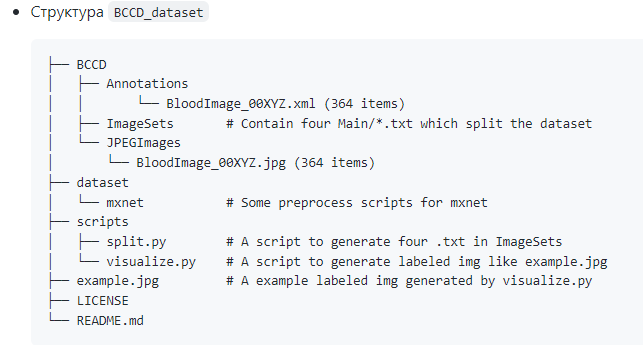

In [ ]:
list_pic = Glob('/content/BCCD_Dataset-1.0/BCCD/Annotations/*.xml')
picture =[]
target = []
xmin = []
ymin = []
xmax = []
ymax = []
for i in list_pic:
  tree = ET.parse(i)
  root = tree.getroot()
  pic_name = (root[1].text)
  for el in root.findall('object'):
    picture.append(pic_name)
    target.append(el.find('name').text)
    xmin.append(el.find('bndbox').find('xmin').text)
    ymin.append(el.find('bndbox').find('ymin').text)
    xmax.append(el.find('bndbox').find('xmax').text)
    ymax.append(el.find('bndbox').find('ymax').text)

name_col = ['ImageID', 'LabelName', 'XMin', 'YMin', 'XMax', 'YMax']
lst = picture, target, xmin, ymin, xmax, ymax
df = pd.DataFrame(np.column_stack(lst), columns = name_col)
DF_RAW = df = df[df.ImageID.str.contains('.jpg')]

df[['XMin','XMax']] = df[['XMin','XMax']].astype(float)/640
df[['YMin','YMax']] = df[['YMin','YMax']].astype(float)/480
df.sample(10)

,ImageID,LabelName,XMin,YMin,XMax,YMax
646,BloodImage_00043.jpg,Platelets,0.276562,0.158333,0.329688,0.239583
2969,BloodImage_00026.jpg,RBC,0.278125,0.004167,0.448437,0.235417
40,BloodImage_00408.jpg,RBC,0.604688,0.283333,0.750000,0.527083
1668,BloodImage_00042.jpg,Platelets,0.626563,0.372917,0.704688,0.447917
4711,BloodImage_00288.jpg,RBC,0.448437,0.154167,0.628125,0.391667
1434,BloodImage_00387.jpg,RBC,0.232813,0.331250,0.442188,0.537500
2993,BloodImage_00247.jpg,RBC,0.685937,0.710417,0.871875,0.964583
2194,BloodImage_00073.jpg,RBC,0.037500,0.002083,0.223438,0.189583
3117,BloodImage_00103.jpg,Platelets,0.070312,0.385417,0.115625,0.439583
4026,BloodImage_00276.jpg,Platelets,0.548438,0.660417,0.596875,0.727083


In [ ]:
df.shape

(4852, 6)

In [ ]:
df[df['ImageID'] == 'BloodImage_00070.jpg'] # проверяем рэндомно, что в картинке не одна коробка

,ImageID,LabelName,XMin,YMin,XMax,YMax
61,BloodImage_00070.jpg,RBC,0.185938,0.820833,0.364063,0.997917
62,BloodImage_00070.jpg,RBC,0.292187,0.002083,0.470313,0.177083
63,BloodImage_00070.jpg,RBC,0.782813,0.479167,0.948438,0.679167
64,BloodImage_00070.jpg,RBC,0.812500,0.800000,0.978125,1.000000
65,BloodImage_00070.jpg,RBC,0.467187,0.364583,0.646875,0.585417
66,BloodImage_00070.jpg,RBC,0.150000,0.043750,0.329688,0.264583
67,BloodImage_00070.jpg,RBC,0.070312,0.247917,0.250000,0.468750
68,BloodImage_00070.jpg,RBC,0.073438,0.547917,0.242188,0.804167
69,BloodImage_00070.jpg,RBC,0.834375,0.614583,1.000000,0.812500
70,BloodImage_00070.jpg,RBC,0.670312,0.291667,0.835938,0.489583


In [ ]:
len(picture),len(target),len(xmin),len(ymin)

(4888, 4888, 4888, 4888)



---



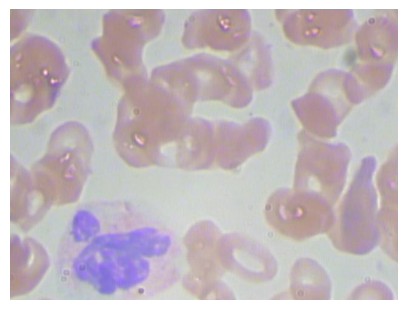

In [ ]:
show('/content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00001.jpg',sz=5)

In [ ]:
img = read('/content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00001.jpg', 1)
img.shape

(480, 640, 3)

In [ ]:
%%capture
!pip install selectivesearch
import selectivesearch
from skimage.segmentation import felzenszwalb

In [ ]:
segments_fz = felzenszwalb(img, scale=200)

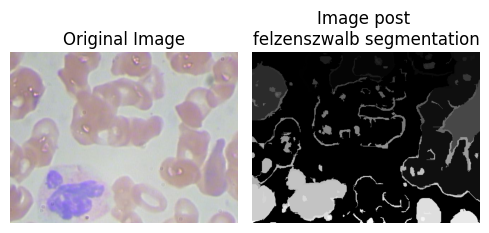

In [ ]:
subplots([img, segments_fz], titles=['Original Image','Image post \nfelzenszwalb segmentation'], figsize=(5,5), nc=2)

In [ ]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=20, min_size=20)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.03*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

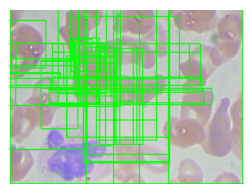

In [ ]:
candidates = extract_candidates(img)
show(img, bbs = candidates,sz=3)



---



In [ ]:
DATA_ROOT = '/content/BCCD_Dataset-1.0/BCCD/'
IMAGE_ROOT = f'{DATA_ROOT}/JPEGImages'
#DF_RAW = df = pd.read_csv(f'{DATA_ROOT}/df.csv')

df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
num_classes

4

In [ ]:
target2label

{1: 'RBC', 2: 'WBC', 3: 'Platelets', 0: 'background'}

In [ ]:
Glob(IMAGE_ROOT+'/*')[:5]

[» /content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00201.jpg,
 » /content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00408.jpg,
 » /content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00182.jpg,
 » /content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00206.jpg,
 » /content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00177.jpg]

In [ ]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique() # список уникальных картинок
        logger.info(f'{len(self)} items loaded') # хз, похоже на результат не влияет

    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix] # перебираем уникальные картинка
        img_path = find(image_id, self.files) # путь до уникальных картинок
        img = Image.open(img_path).convert("RGB") # вытаскиваем картинку, переводим в RGB
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.# масштабирование, нормализация
        data = df[df['ImageID'] == image_id] # вытаскиваем строки относящиеся к картинке
        labels = data['LabelName'].values.tolist() # создаем список меток
        data = data[['XMin','YMin','XMax','YMax']].values # !array список списков с коробками для каждой картинки
        data[:,[0,2]] *= self.w # масштабирование w коробок (они уже нормализованы)
        data[:,[1,3]] *= self.h # масштабирование h коробок (они уже нормализованы)
        boxes = data.astype(np.uint32).tolist() # простой список списков с коробками для каждой картинки
                                                # + изменение типа данных
        return img, boxes, labels

    def collate_fn(self, batch): # работат с пакетами
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item # разделяем данные в пакете
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels
    def __len__(self):
        return len(self.image_infos)

In [ ]:
df[df['ImageID'] == 'BloodImage_00001.jpg']['LabelName'].values.tolist()[:5] # форма выхода меток

['WBC', 'RBC', 'RBC', 'RBC', 'RBC']

In [ ]:
df[df['ImageID'] == 'BloodImage_00001.jpg'][['XMin','YMin','XMax','YMax']].values[:5]

array([[0.10625   , 0.65625   , 0.446875  , 1.        ],
       [0.540625  , 0.75208333, 0.696875  , 0.94583333],
       [0.0828125 , 0.37291667, 0.228125  , 0.62291667],
       [0.7015625 , 0.83333333, 0.8375    , 1.        ],
       [0.7203125 , 0.275     , 0.85625   , 0.44166667]])

In [ ]:
df[df['ImageID'] == 'BloodImage_00001.jpg'][['XMin','YMin','XMax','YMax']].values[:5].tolist() # форма выхода коробок

[[0.10625, 0.65625, 0.446875, 1.0],
 [0.540625, 0.7520833333333333, 0.696875, 0.9458333333333333],
 [0.0828125, 0.3729166666666667, 0.228125, 0.6229166666666667],
 [0.7015625, 0.8333333333333334, 0.8375, 1.0],
 [0.7203125, 0.275, 0.85625, 0.44166666666666665]]

In [ ]:
df.sample(4)

,ImageID,LabelName,XMin,YMin,XMax,YMax
759,BloodImage_00207.jpg,RBC,0.001563,0.243750,0.143750,0.460417
2345,BloodImage_00002.jpg,RBC,0.389062,0.362500,0.576562,0.616667
2889,BloodImage_00405.jpg,RBC,0.253125,0.237500,0.423438,0.458333
1541,BloodImage_00073.jpg,RBC,0.395313,0.802083,0.610938,1.000000


[05/09/23 13:06:37] INFO     361 items loaded                           ]8;id=391111;file://<ipython-input-32-b1f1811f0b46>\<ipython-input-32-b1f1811f0b46>]8;;\:]8;id=653795;file://<ipython-input-32-b1f1811f0b46>#__init__:25\__init__:25]8;;\

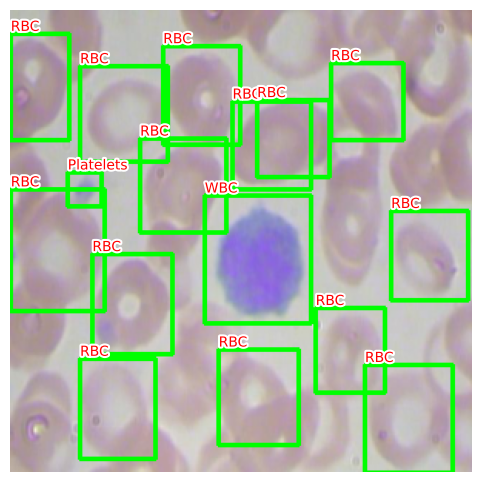

In [ ]:
ds = OpenDataset(df=DF_RAW)
im,bbs,clss = ds[22]
show(im, bbs=bbs, texts=clss, sz=6, text_sz=10)

In [ ]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

[05/09/23 13:37:32] INFO     324 items loaded                           ]8;id=582635;file://<ipython-input-32-b1f1811f0b46>\<ipython-input-32-b1f1811f0b46>]8;;\:]8;id=883740;file://<ipython-input-32-b1f1811f0b46>#__init__:25\__init__:25]8;;\

                    INFO     37 items loaded                            ]8;id=742436;file://<ipython-input-32-b1f1811f0b46>\<ipython-input-32-b1f1811f0b46>]8;;\:]8;id=200216;file://<ipython-input-32-b1f1811f0b46>#__init__:25\__init__:25]8;;\

In [ ]:
for i in train_loader:
  print(i)
  break

(
    tensor[4, 3, 300, 300] n=1080000 (4.1Mb) x∈[-0.670, 2.466] μ=1.168 σ=0.403,
    [
        tensor[12, 4] n=48 x∈[0., 1.000] μ=0.540 σ=0.299,
        tensor[19, 4] n=76 x∈[0., 0.997] μ=0.455 σ=0.271,
        tensor[12, 4] n=48 x∈[0., 0.950] μ=0.455 σ=0.273,
        tensor[4, 4] n=16 x∈[0.117, 0.950] μ=0.512 σ=0.246
    ],
    [
        tensor[12] i64 x∈[1, 2] μ=1.083 σ=0.289,
        tensor[19] i64 x∈[1, 3] μ=1.158 σ=0.501,
        tensor[12] i64 x∈[1, 3] μ=1.417 σ=0.793,
        tensor[4] i64 x∈[1, 2] μ=1.250 σ=0.500 [1, 1, 1, 2]
    ]
)

In [ ]:
картинка, рамка, имя = next(iter(train_loader))
inspect(картинка, рамка, имя)

══════════════════════════════════════════════════════════════════

Tensor  Shape: torch.Size([4, 3, 300, 300])     Min: -0.898     Max: 2.501      Mean: 1.207     dtype: 
torch.float32 @ cuda:0

══════════════════════════════════════════════════════════════════

list of 4 items

Tensor  Shape: torch.Size([12, 4])      Min: 0.000      Max: 1.000      Mean: 0.375     dtype: 
torch.float32 @ cuda:0

Tensor  Shape: torch.Size([15, 4])      Min: 0.000      Max: 0.993      Mean: 0.454     dtype: 
torch.float32 @ cuda:0

Tensor  Shape: torch.Size([12, 4])      Min: 0.000      Max: 1.000      Mean: 0.492     dtype: 
torch.float32 @ cuda:0

Tensor  Shape: torch.Size([13, 4])      Min: 0.000      Max: 1.000      Mean: 0.517     dtype: 
torch.float32 @ cuda:0

══════════════════════════════════════════════════════════════════

list of 4 items

Tensor  Shape: torch.Size([12]) Min: 1.000      Max: 3.000      Mean: 1.417     dtype: torch.int64 @ cuda:0

Tensor  Shape: torch.Size([15]) Min: 1.000      Max: 3.000      Mean: 1.200     dtype: torch.int64 @ cuda:0

Tensor  Shape: torch.Size([12]) Min: 1.000      Max: 3.000      Mean: 1.167     dtype: torch.int64 @ cuda:0

Tensor  Shape: torch.Size([13]) Min: 1.000      Max: 3.000      Mean: 1.231     dtype: torch.int64 @ cuda:0

══════════════════════════════════════════════════════════════════

In [ ]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [ ]:
%%capture
import os
!pip install -q torch_snippets
!git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

In [ ]:
from model import SSD300, MultiBoxLoss
from detect import *

In [ ]:
n_epochs = 3

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), end='\r')

EPOCH: 3.000  val_loss: 2.527  (4199.95s - 0.00s remaining)

100%|██████████| 104/104 [00:00<00:00, 8193.54it/s]


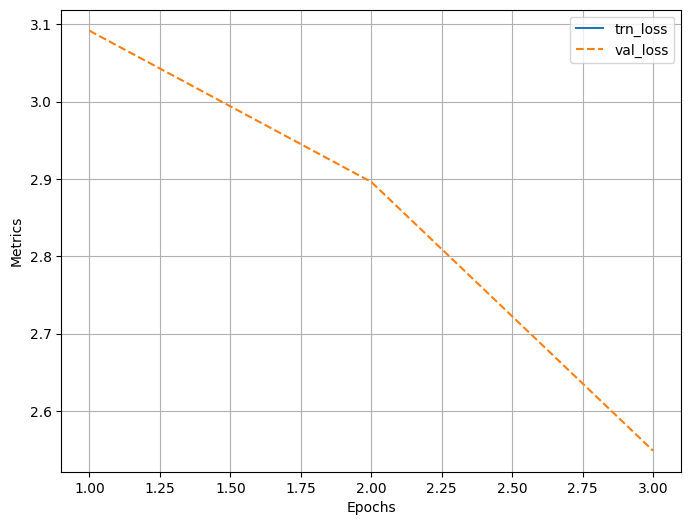

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])



---



### Saving

In [ ]:
save_path = '/content/бактерии.pth'
torch.save(model.state_dict(), save_path)
!du -hsc {save_path} # size of the model on disk

92M	/content/бактерии.pth
92M	total


### Loading

In [ ]:
load_path = '/content/бактерии.pth'
model.load_state_dict(torch.load(load_path))



---



In [ ]:
image_paths = Glob(f'{DATA_ROOT}/JPEGImages/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

[[257, 45, 493, 245]]
['WBC @ 0.93']

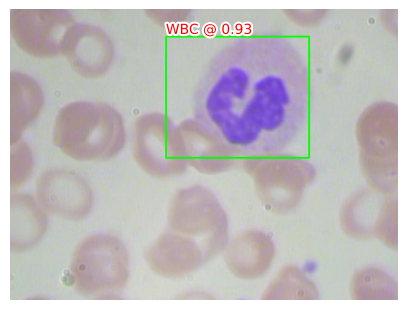

[[197, 362, 301, 465], [406, 369, 509, 470], [-11, 2, 215, 213]]
['RBC @ 0.95', 'RBC @ 0.95', 'WBC @ 0.91']

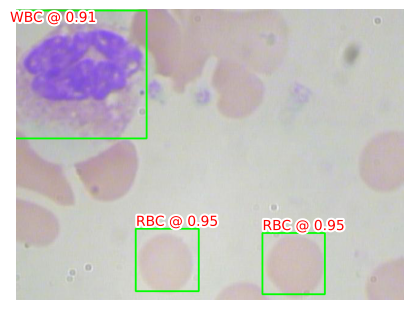

[[272, 70, 513, 268]]
['WBC @ 0.95']

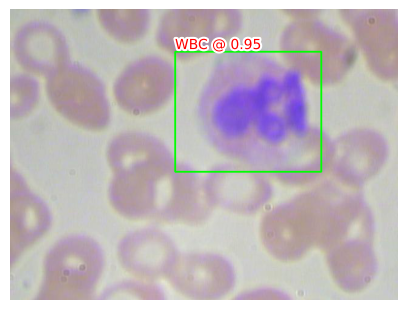

In [ ]:
image_paths = Glob(f'{DATA_ROOT}/JPEGImages/*')
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=50, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10,sz=5)
